In [60]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [61]:
df = pd.read_csv('../input/Chicago_Crimes_2012_to_2017.csv')
df.columns

Index(['Unnamed: 0', 'ID', 'Case Number', 'Date', 'Block', 'IUCR',
       'Primary Type', 'Description', 'Location Description', 'Arrest',
       'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code',
       'X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'Latitude',
       'Longitude', 'Location'],
      dtype='object')

In [62]:
print("Total Crimes: ",len(df))
print("Total Cameras",len(df['X Coordinate'].unique()))

Total Crimes:  1456714
Total Cameras 67715


In [63]:
#IMPORTS
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [64]:
df["Date"] = df["Date"].apply(lambda x: x[11:])

In [65]:
pd.isnull(df).sum()

Unnamed: 0                  0
ID                          0
Case Number                 1
Date                        0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     1658
Arrest                      0
Domestic                    0
Beat                        0
District                    1
Ward                       14
Community Area             40
FBI Code                    0
X Coordinate            37083
Y Coordinate            37083
Year                        0
Updated On                  0
Latitude                37083
Longitude               37083
Location                37083
dtype: int64

In [66]:
print(len(df))
df = df.dropna()
print(len(df))

1456714
1418365


In [67]:
from tqdm import tqdm
def check_date(str_time, hour):
    time, ap = str_time.split(" ")
    if(ap=="AM"):
        if(int(time.split(":")[0])==hour):
            return True
    else:
        if(int(time.split(":")[0])+12==hour):
            return True
    return False
dict_hours = dict()
for i in tqdm(range(1,25)):
    dict_hours[i] = df[df["Date"].apply(lambda x: check_date(x, i))]
print(len(dict_hours))

100%|██████████| 24/24 [00:39<00:00,  1.67s/it]

24


1418365


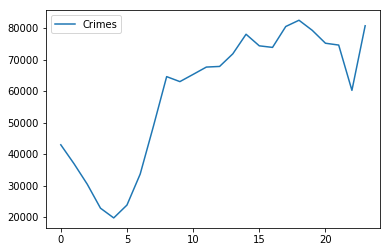

In [75]:
print(len(df))
crimes_interval_df = pd.DataFrame({"Crimes":[len(dict_hours[key]) for key in range(1,25)]})
#Draw time graph
lines = crimes_interval_df.plot.line()

In [69]:
mean_by_block = df.groupby("Block", as_index = False).mean()

In [70]:
dict_centroids = dict()
for i in tqdm(range(1,25)):
    kmeans = MiniBatchKMeans(n_clusters=50)
    points = dict_hours[i][["X Coordinate","Y Coordinate"]]
    kmeans.fit(points)
    dict_centroids[i] = kmeans.cluster_centers_

100%|██████████| 24/24 [00:10<00:00,  1.65it/s]


In [71]:
dict_final_for_hours = dict()
X = mean_by_block[["X Coordinate","Y Coordinate"]].values
for key in tqdm(range(1,25)):
    closest, _ = pairwise_distances_argmin_min(dict_centroids[key], X)
    dict_final_for_hours[key] = closest

100%|██████████| 24/24 [00:00<00:00, 62.15it/s]


In [72]:
mean_by_block.head()

,Block,Unnamed: 0,ID,Arrest,Domestic,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Latitude,Longitude
0,0000X E 100TH PL,3.302441e+06,9.699165e+06,0.477876,0.088496,511.0,5.0,9.0,49.0,1.178512e+06,1.838354e+06,2014.070796,41.711744,-87.621845
1,0000X E 100TH ST,3.351465e+06,9.621225e+06,0.363636,0.231405,511.0,5.0,9.0,49.0,1.178503e+06,1.838685e+06,2013.884298,41.712653,-87.621871
2,0000X E 101ST PL,3.737384e+06,9.733296e+06,0.352273,0.295455,511.0,5.0,9.0,49.0,1.178543e+06,1.837691e+06,2014.045455,41.709924,-87.621754
3,0000X E 101ST ST,3.105716e+06,9.417665e+06,0.408163,0.204082,511.0,5.0,9.0,49.0,1.178527e+06,1.838022e+06,2013.428571,41.710833,-87.621801
4,0000X E 102ND PL,3.139583e+06,9.474210e+06,0.463277,0.186441,511.0,5.0,9.0,49.0,1.178468e+06,1.837024e+06,2013.638418,41.708096,-87.622047


In [73]:
import folium
chicago_map = folium.Map(location=[41.864073,-87.706819],zoom_start=11,
                        tiles="CartoDB dark_matter")
for index in dict_final_for_hours[1]:
    lat = mean_by_block.iloc[index]["Latitude"]
    long = mean_by_block.iloc[index]["Longitude"]
    folium.CircleMarker(location = [lat, long], fill = True).add_to(chicago_map)

In [74]:
chicago_map